In [ ]:
# First, let's examine the checkpoint file structure
checkpoint_path = '/home/ubuntu/dev/data/numerical/ns_transient_2d/resolution_m30_pFalse/checkpoints/checkpoint_1000_samples.pt'
checkpoint_data = torch.load(checkpoint_path, weights_only=False)

print("Checkpoint data type:", type(checkpoint_data))
if isinstance(checkpoint_data, list):
    print(f"Number of entries: {len(checkpoint_data)}")
    print(f"First entry type: {type(checkpoint_data[0])}")
    if isinstance(checkpoint_data[0], tuple):
        print(f"First entry has {len(checkpoint_data[0])} tensors")
        for i, tensor in enumerate(checkpoint_data[0]):
            print(f"  Tensor {i} shape: {tensor.shape}")
elif isinstance(checkpoint_data, dict):
    print("Checkpoint data keys:", checkpoint_data.keys())
    for key, value in checkpoint_data.items():
        if hasattr(value, 'shape'):
            print(f"  {key}: {value.shape}")
        else:
            print(f"  {key}: {type(value)}")
else:
    print("Checkpoint data structure:", checkpoint_data)

/tmp/ipykernel_2093353/3426386927.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/ipykernel_2093353/3426386927.py:19: FutureWar

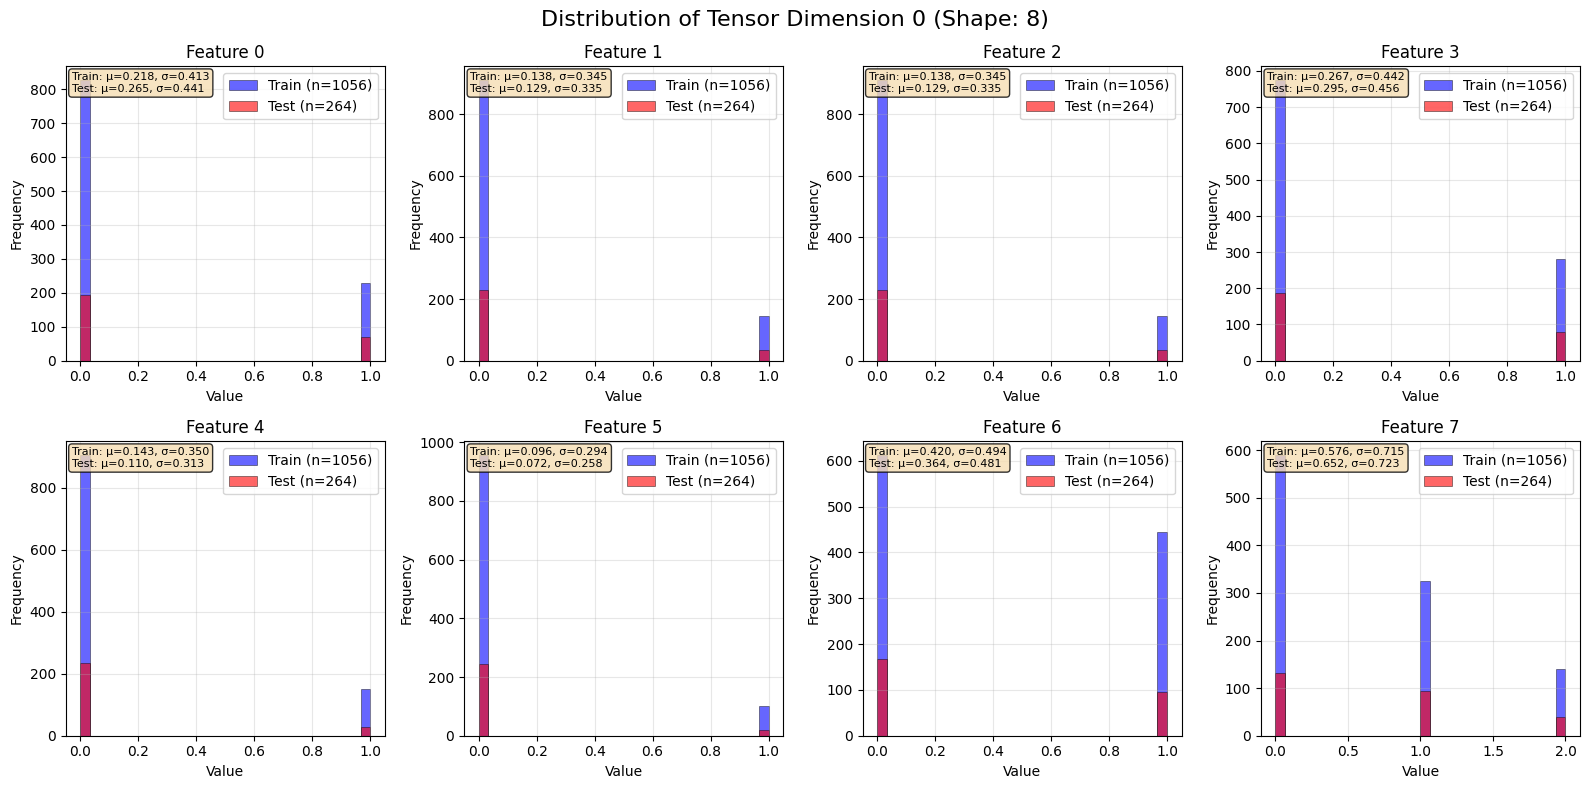

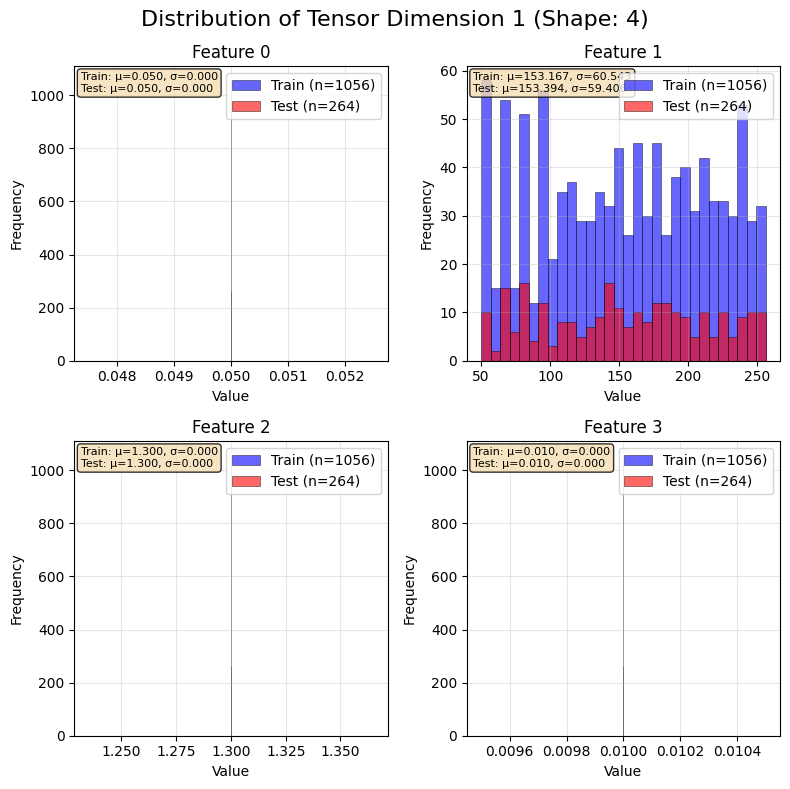

/home/ubuntu/miniconda3/envs/simubench/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ubuntu/miniconda3/envs/simubench/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/ubuntu/miniconda3/envs/simubench/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


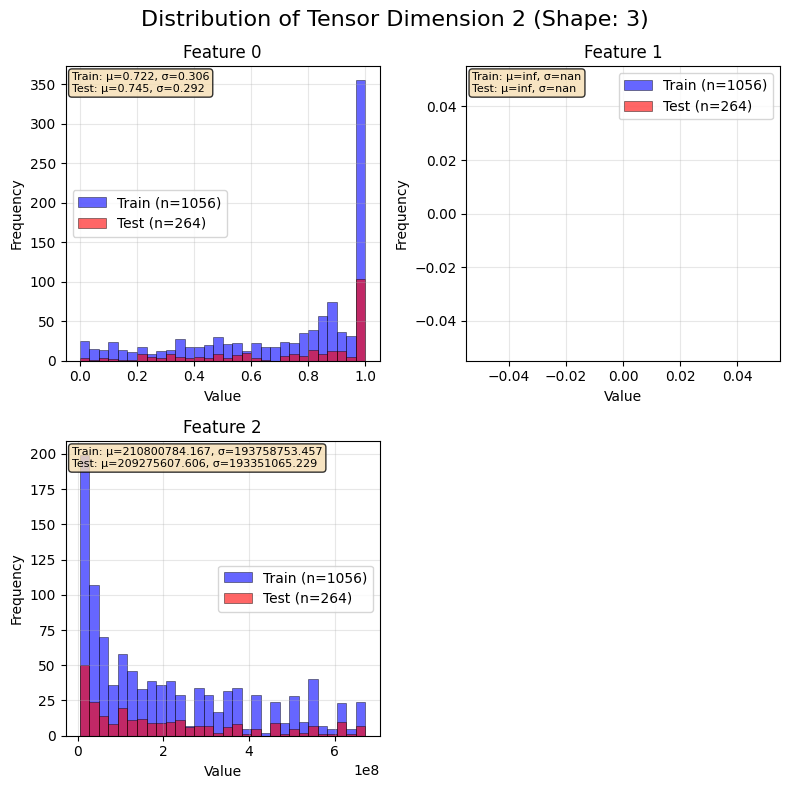

Data folder: /home/ubuntu/dev/data/numerical/ns_transient_2d/resolution_m30_pFalse
Train samples: 1056
Test samples: 264
Number of tensor dimensions: 3
Dimension 0: shape torch.Size([1056, 8]), train range: [0.0000, 2.0000], test range: [0.0000, 2.0000]
Dimension 1: shape torch.Size([1056, 4]), train range: [0.0100, 256.0000], test range: [0.0100, 256.0000]
Dimension 2: shape torch.Size([1056, 3]), train range: [0.0000, inf], test range: [0.0000, inf]


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_data_distributions(data_folder, bins=30):
    """
    Plot data distributions with histograms comparing train and test data.
    
    Args:
        data_folder: Path to folder containing train.pt and test.pt files
        bins: Number of bins for histograms
    """
    # Load data
    train_path = os.path.join(data_folder, 'train', 'train.pt')
    test_path = os.path.join(data_folder, 'test', 'test.pt')
    
    train_data = torch.load(train_path)
    test_data = torch.load(test_path)
    
    # Extract tensors from tuples and organize by dimension
    train_tensors = [[] for _ in range(len(train_data[0]))]
    test_tensors = [[] for _ in range(len(test_data[0]))]
    
    # Collect all tensors by dimension
    for item in train_data:
        for i, tensor in enumerate(item):
            train_tensors[i].append(tensor)
    
    for item in test_data:
        for i, tensor in enumerate(item):
            test_tensors[i].append(tensor)
    
    # Stack tensors for each dimension
    train_stacked = [torch.stack(tensors) for tensors in train_tensors]
    test_stacked = [torch.stack(tensors) for tensors in test_tensors]
    
    # Create subplots for each tensor dimension
    n_dims = len(train_stacked)
    
    for dim_idx, (train_tensor, test_tensor) in enumerate(zip(train_stacked, test_stacked)):
        feature_dim = train_tensor.shape[1]
        
        # Create subplots for each feature in this dimension
        fig, axes = plt.subplots(2, (feature_dim + 1) // 2, figsize=(4 * ((feature_dim + 1) // 2), 8))
        if feature_dim == 1:
            axes = np.array([axes]).reshape(2, 1)
        elif feature_dim <= 2:
            axes = axes.reshape(2, -1)
        
        fig.suptitle(f'Distribution of Tensor Dimension {dim_idx} (Shape: {train_tensor.shape[1]})', fontsize=16)
        
        for feat_idx in range(feature_dim):
            row = feat_idx // ((feature_dim + 1) // 2)
            col = feat_idx % ((feature_dim + 1) // 2)
            
            if row >= axes.shape[0] or col >= axes.shape[1]:
                continue
                
            ax = axes[row, col]
            
            # Get data for this feature
            train_feature = train_tensor[:, feat_idx].numpy()
            test_feature = test_tensor[:, feat_idx].numpy()
            
            # Determine common range for both histograms
            all_data = np.concatenate([train_feature, test_feature])
            data_min, data_max = all_data.min(), all_data.max()
            bin_edges = np.linspace(data_min, data_max, bins + 1)
            
            # Plot histograms
            ax.hist(train_feature, bins=bin_edges, alpha=0.6, label=f'Train (n={len(train_feature)})', 
                   color='blue', edgecolor='black', linewidth=0.5)
            ax.hist(test_feature, bins=bin_edges, alpha=0.6, label=f'Test (n={len(test_feature)})', 
                   color='red', edgecolor='black', linewidth=0.5)
            
            # Customize plot
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Feature {feat_idx}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add statistics text
            train_mean, train_std = train_feature.mean(), train_feature.std()
            test_mean, test_std = test_feature.mean(), test_feature.std()
            stats_text = f'Train: μ={train_mean:.3f}, σ={train_std:.3f}\nTest: μ={test_mean:.3f}, σ={test_std:.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Hide unused subplots
        total_subplots = axes.shape[0] * axes.shape[1]
        for idx in range(feature_dim, total_subplots):
            row = idx // axes.shape[1]
            col = idx % axes.shape[1]
            if row < axes.shape[0] and col < axes.shape[1]:
                axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"Data folder: {data_folder}")
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    print(f"Number of tensor dimensions: {n_dims}")
    for i, (train_tensor, test_tensor) in enumerate(zip(train_stacked, test_stacked)):
        print(f"Dimension {i}: shape {train_tensor.shape}, train range: [{train_tensor.min():.4f}, {train_tensor.max():.4f}], test range: [{test_tensor.min():.4f}, {test_tensor.max():.4f}]")

# Example usage:
plot_data_distributions('/home/ubuntu/dev/data/numerical/ns_transient_2d/resolution_m30_pFalse')

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_data_distributions(data_folder):
    """
    Plot data distributions with barplots comparing train and test data.
    
    Args:
        data_folder: Path to folder containing train.pt and test.pt files
    """
    # Load data
    train_path = os.path.join(data_folder, 'train.pt')
    test_path = os.path.join(data_folder, 'test.pt')
    
    train_data = torch.load(train_path)
    test_data = torch.load(test_path)
    
    # Extract tensors from tuples and organize by dimension
    train_tensors = [[] for _ in range(len(train_data[0]))]
    test_tensors = [[] for _ in range(len(test_data[0]))]
    
    # Collect all tensors by dimension
    for item in train_data:
        for i, tensor in enumerate(item):
            train_tensors[i].append(tensor)
    
    for item in test_data:
        for i, tensor in enumerate(item):
            test_tensors[i].append(tensor)
    
    # Stack tensors for each dimension
    train_stacked = [torch.stack(tensors) for tensors in train_tensors]
    test_stacked = [torch.stack(tensors) for tensors in test_tensors]
    
    # Create subplots for each tensor dimension
    n_dims = len(train_stacked)
    fig, axes = plt.subplots(1, n_dims, figsize=(5*n_dims, 6))
    if n_dims == 1:
        axes = [axes]
    
    for dim_idx, (train_tensor, test_tensor) in enumerate(zip(train_stacked, test_stacked)):
        ax = axes[dim_idx]
        
        # Get the feature dimension size
        feature_dim = train_tensor.shape[1]
        
        # Calculate statistics for each feature
        train_means = train_tensor.mean(dim=0).numpy()
        test_means = test_tensor.mean(dim=0).numpy()
        train_stds = train_tensor.std(dim=0).numpy()
        test_stds = test_tensor.std(dim=0).numpy()
        
        # Create bar positions
        x = np.arange(feature_dim)
        width = 0.35
        
        # Create bars
        bars1 = ax.bar(x - width/2, train_means, width, yerr=train_stds, 
                      label='Train', alpha=0.7, color='blue', capsize=5)
        bars2 = ax.bar(x + width/2, test_means, width, yerr=test_stds,
                      label='Test', alpha=0.7, color='red', capsize=5)
        
        # Customize plot
        ax.set_xlabel(f'Feature Index (Dimension {dim_idx})')
        ax.set_ylabel('Mean Value')
        ax.set_title(f'Data Distribution Comparison\n(Tensor Dimension {train_tensor.shape[1]})')
        ax.set_xticks(x)
        ax.set_xticklabels([f'F{i}' for i in range(feature_dim)])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        def add_value_labels(bars, values):
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.annotate(f'{value:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontsize=8)
        
        add_value_labels(bars1, train_means)
        add_value_labels(bars2, test_means)
    
    plt.tight_layout()
    plt.suptitle(f'Train vs Test Data Distribution Comparison\n{os.path.basename(data_folder)}', 
                 y=1.02, fontsize=14)
    plt.show()
    
    # Print summary statistics
    print(f"Data folder: {data_folder}")
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    print(f"Number of tensor dimensions: {n_dims}")
    for i, (train_tensor, test_tensor) in enumerate(zip(train_stacked, test_stacked)):
        print(f"Dimension {i}: shape {train_tensor.shape[1]}, train mean: {train_tensor.mean():.4f}, test mean: {test_tensor.mean():.4f}")

# Example usage:
plot_data_distributions('/home/ubuntu/dev/data/numerical/ns_channel_2d/mesh_x_combined')

/tmp/ipykernel_1758523/905046307.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/dev/data/numerical/ns_channel_2d/mesh_x_combined/train.pt'

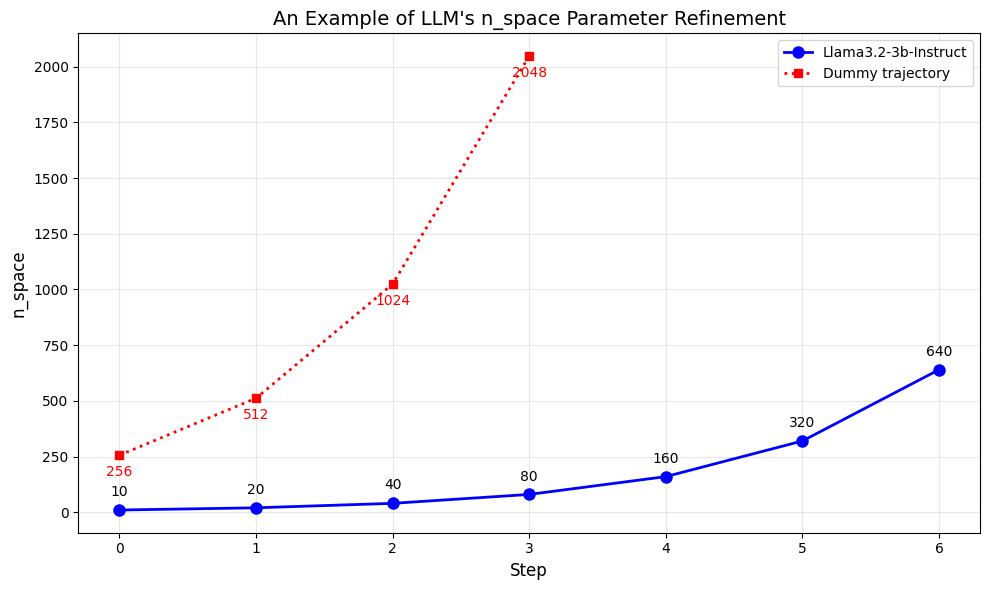

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_n_space_refinement(filename, qid, iterative_questions_path):
    """
    Plot the refinement of 'n_space' parameter against number of steps
    
    Args:
        filename: Path to the JSON progress file
        qid: QID to plot
        iterative_questions_path: Path to the iterative questions file containing dummy trajectories
    """
    # Load the JSON data
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Load the iterative questions data for dummy trajectory
    with open(iterative_questions_path, 'r') as f:
        iterative_data = json.load(f)
    
    # Find the result with the specified QID
    target_result = None
    for result in data['results']:
        if result['QID'] == qid:
            target_result = result
            break
    
    if target_result is None:
        print(f"QID {qid} not found in the data")
        return
    
    # Find the dummy trajectory for the specified QID
    dummy_trajectory = None
    for entry in iterative_data:
        if entry['QID'] == qid:
            dummy_trajectory = [param['n_space'] for param in entry['param_history']]
            break
    
    if dummy_trajectory is None:
        print(f"QID {qid} not found in iterative questions data")
        return
    
    # Extract n_space values from param_sequence
    n_space_values = []
    for param in target_result['param_sequence']:
        n_space_values.append(param['n_space'])
    
    # Create step numbers (0, 1, 2, ...)
    steps = list(range(len(n_space_values)))
    dummy_steps = list(range(len(dummy_trajectory)))
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(steps, n_space_values, 'bo-', linewidth=2, markersize=8, label=f'Llama3.2-3b-Instruct')
    plt.plot(dummy_steps, dummy_trajectory, 'r:', linewidth=2, markersize=6, marker='s', label='Dummy trajectory')
    
    plt.xlabel('Step', fontsize=12)
    plt.ylabel('n_space', fontsize=12)
    plt.title(f'An Example of LLM\'s n_space Parameter Refinement', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add value annotations on points
    for i, value in enumerate(n_space_values):
        plt.annotate(str(value), (i, value), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Add value annotations on dummy trajectory points
    for i, value in enumerate(dummy_trajectory):
        plt.annotate(str(value), (i, value), textcoords="offset points", xytext=(0,-15), ha='center', color='red')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_n_space_refinement('/home/ubuntu/dev/SimulCost-Bench/log_model_tool_call/euler_1d/medium/n_space/iterative_llama3.2_3b_base_progress.json', 
                       7, 
                       '/home/ubuntu/dev/SimulCost-Bench/data/euler_1d/n_space/medium/iterative_questions.json')

In [ ]:
import torch
import numpy as np

# Load and examine the training data
train_data = torch.load('/home/ubuntu/dev/data/numerical/ns_channel_2d/mesh_x_combined/train/train.pt')
print("Train data keys:", train_data.keys())
print("Train data shapes:")
for key, value in train_data.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value.shape}")
    else:
        print(f"  {key}: {type(value)}")